# parameter tuned
reference : https://www.kaggle.com/znyksh/fork-lightgbm-with-simple-features/versions#base=4143658&new=4153250

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
st = time.time()
df = pd.read_csv('./kageyama_feature_matrix_96.0.csv')
time.time() - st

74.81653594970703

In [3]:
train_cood = pd.read_csv('./cood/train-tSNE-coordinates.csv')

In [4]:
train_cood.head()

,TARGET,tSNE_X,tSNE_Y
0,1,3.03081,-6.236150
1,0,11.16150,-2.799430
2,0,-10.78970,0.930869
3,0,8.62630,-0.484253
4,0,-4.16315,-2.660070


In [5]:
test_cood = pd.read_csv('./cood/test-tSNE-coordinates.csv')

In [6]:
test_cood.head()

,tSNE_X,tSNE_Y
0,-9.60385,6.26010
1,-2.30006,-5.94580
2,7.91223,6.36806
3,3.52808,-7.15006
4,-8.46879,-5.68575


In [7]:
df = df.drop('SK_ID_CURR', axis=1)

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 21/21 [00:20<00:00,  1.05it/s]


14

In [9]:
train_df['tSNE_X'] = train_cood['tSNE_X']
train_df['tSNE_Y'] = train_cood['tSNE_Y']


In [10]:
test_df['tSNE_X'] = test_cood['tSNE_X']
test_df['tSNE_Y'] = test_cood['tSNE_Y']

In [11]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=25, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=.8,
        subsample=.87,
        max_depth=8,
        reg_alpha=.0415,
        reg_lambda=.0735,
        min_split_gain=.02,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758745	valid_1's auc: 0.752002
[200]	training's auc: 0.780436	valid_1's auc: 0.764017
[300]	training's auc: 0.798083	valid_1's auc: 0.773678
[400]	training's auc: 0.80955	valid_1's auc: 0.778861
[500]	training's auc: 0.818848	valid_1's auc: 0.781391
[600]	training's auc: 0.826951	valid_1's auc: 0.783155
[700]	training's auc: 0.83393	valid_1's auc: 0.784871
[800]	training's auc: 0.84042	valid_1's auc: 0.785585
[900]	training's auc: 0.846352	valid_1's auc: 0.7867
[1000]	training's auc: 0.851988	valid_1's auc: 0.786897
[1100]	training's auc: 0.857241	valid_1's auc: 0.78739
[1200]	training's auc: 0.862228	valid_1's auc: 0.787685
[1300]	training's auc: 0.866983	valid_1's auc: 0.788361
[1400]	training's auc: 0.871667	valid_1's auc: 0.788396
[1500]	training's auc: 0.876114	valid_1's auc: 0.788496
Early stopping, best iteration is:
[1443]	training's auc: 0.873674	valid_1's auc: 0.788648
Fold  1 AUC : 0.78864

[1400]	training's auc: 0.871406	valid_1's auc: 0.787848
[1500]	training's auc: 0.875689	valid_1's auc: 0.788011
[1600]	training's auc: 0.87983	valid_1's auc: 0.788574
[1700]	training's auc: 0.88395	valid_1's auc: 0.788623
Early stopping, best iteration is:
[1645]	training's auc: 0.881675	valid_1's auc: 0.788796
Fold  8 AUC : 0.788796
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758973	valid_1's auc: 0.746529
[200]	training's auc: 0.780659	valid_1's auc: 0.759449
[300]	training's auc: 0.798141	valid_1's auc: 0.768277
[400]	training's auc: 0.809679	valid_1's auc: 0.773322
[500]	training's auc: 0.81907	valid_1's auc: 0.776387
[600]	training's auc: 0.827042	valid_1's auc: 0.777969
[700]	training's auc: 0.833806	valid_1's auc: 0.779024
[800]	training's auc: 0.840241	valid_1's auc: 0.779914
[900]	training's auc: 0.846312	valid_1's auc: 0.781
[1000]	training's auc: 0.852047	valid_1's auc: 0.781591
[1100]	training's auc: 0.857367	valid_1's auc: 0.78248

[100]	training's auc: 0.758271	valid_1's auc: 0.758384
[200]	training's auc: 0.779833	valid_1's auc: 0.771973
[300]	training's auc: 0.797418	valid_1's auc: 0.782423
[400]	training's auc: 0.809124	valid_1's auc: 0.788093
[500]	training's auc: 0.81857	valid_1's auc: 0.791744
[600]	training's auc: 0.826539	valid_1's auc: 0.793724
[700]	training's auc: 0.833789	valid_1's auc: 0.794944
[800]	training's auc: 0.840213	valid_1's auc: 0.795626
[900]	training's auc: 0.84649	valid_1's auc: 0.796092
[1000]	training's auc: 0.852012	valid_1's auc: 0.796229
[1100]	training's auc: 0.857298	valid_1's auc: 0.796391
[1200]	training's auc: 0.862302	valid_1's auc: 0.796784
[1300]	training's auc: 0.867035	valid_1's auc: 0.796918
[1400]	training's auc: 0.871619	valid_1's auc: 0.797121
Early stopping, best iteration is:
[1389]	training's auc: 0.87113	valid_1's auc: 0.797151
Fold 17 AUC : 0.797151
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758348	valid_1's auc: 0.759

[1100]	training's auc: 0.85715	valid_1's auc: 0.796551
[1200]	training's auc: 0.862206	valid_1's auc: 0.796945
[1300]	training's auc: 0.867037	valid_1's auc: 0.797306
[1400]	training's auc: 0.871571	valid_1's auc: 0.797511
[1500]	training's auc: 0.876142	valid_1's auc: 0.79772
[1600]	training's auc: 0.880516	valid_1's auc: 0.797939
[1700]	training's auc: 0.884639	valid_1's auc: 0.798053
[1800]	training's auc: 0.888614	valid_1's auc: 0.798172
[1900]	training's auc: 0.892348	valid_1's auc: 0.798277
[2000]	training's auc: 0.895983	valid_1's auc: 0.798532
[2100]	training's auc: 0.899418	valid_1's auc: 0.79857
[2200]	training's auc: 0.903078	valid_1's auc: 0.798558
Early stopping, best iteration is:
[2156]	training's auc: 0.901471	valid_1's auc: 0.798812
Fold 25 AUC : 0.798812
Full AUC score 0.793183


In [12]:
sub.to_csv('./kageyama_96_cood_sub.csv', index=None)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


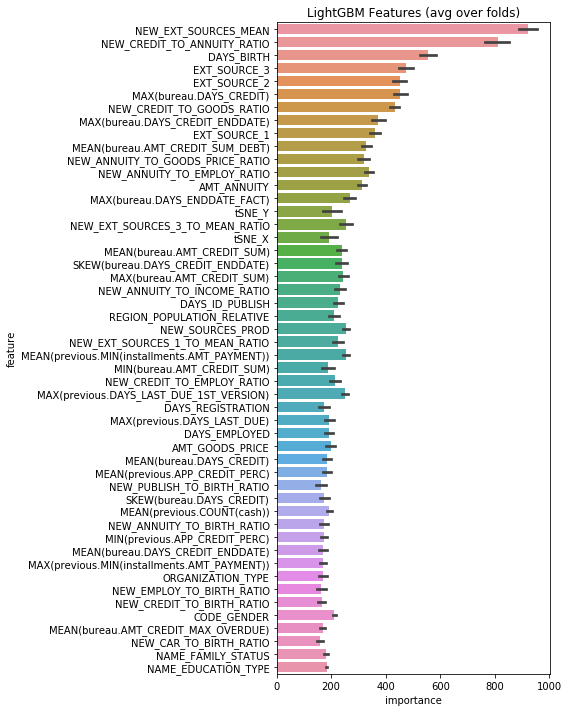

In [14]:
display_importances(feature_importance_df)

In [15]:
time.time() - st

12864.9456949234